<a href="https://colab.research.google.com/github/Hidrovales/Balanco_Hidrico/blob/main/Experimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SIMULAÇÃO DO BALANÇO HÍDRICO DA CULTURA DO MILHO

<table>
  <tr>
    <td><img src="https://github.com/Hidrovales/Balanco_Hidrico/blob/main/Figuras/salinas_vertical_jpg.jpg?raw=true" width="100"></td>
    <td><img src="https://github.com/Hidrovales/Balanco_Hidrico/blob/main/Figuras/logo_color_vertical_big.png?raw=true" width="110"></td>
  </tr>
</table>


[HIDROVALES - GRUPO DE PESQUISA EM RECURSOS HÍDRICOS E AMBIENTAIS DO NORTE DE MINAS GERAIS](http://www.hidrovales.com.br/)

Patrícia O. Lucas, Marcelo R. Vicente e Ronaldo M. Santos

In [1]:
#!pip install earthengine-api
#!pip install ipygee
!git clone https://github.com/Hidrovales/Balanco_Hidrico.git

Cloning into 'Balanco_Hidrico'...
remote: Enumerating objects: 532, done.
remote: Counting objects: 100% (532/532), done.
remote: Compressing objects: 100% (526/526), done.
remote: Total 532 (delta 290), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (532/532), 9.00 MiB | 4.79 MiB/s, done.
Resolving deltas: 100% (290/290), done.


In [3]:
from Balanco_Hidrico import Calcula_ETo, Balanco_Hidrico, Ajuste
import datetime
import pandas as pd
import numpy as np

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

##Upload das base de dados

In [ ]:
dataset_mucuri = Upload_dataset.get_dataset(latitude = -17.7031, longitude = -40.7472, start = '2021-01-01', end = '2021-07-01')
dataset_mucuri.to_csv('dataset_mucuri_01_09.csv', index=False)

dataset_riodoce = Upload_dataset.get_dataset(latitude = -18.8633, longitude = -41.7855, start = '2021-01-01', end = '2021-07-01')
dataset_riodoce.to_csv('dataset_riodoce.csv', index=False)

dataset_jequitinhonha = Upload_dataset.get_dataset(latitude = -16.1133, longitude = -42.1479, start = '2021-01-01', end = '2021-07-01')
dataset_jequitinhonha.to_csv('dataset_jequitinhonha.csv', index=False)

In [4]:
dataset_mucuri = pd.read_csv('https://raw.githubusercontent.com/Hidrovales/Balanco_Hidrico/main/Datasets/dataset_mucuri.csv')
dataset_riodoce = pd.read_csv('https://raw.githubusercontent.com/Hidrovales/Balanco_Hidrico/main/Datasets/dataset_riodoce.csv')
dataset_jequitinhonha = pd.read_csv('https://raw.githubusercontent.com/Hidrovales/Balanco_Hidrico/main/Datasets/dataset_jequitinhonha.csv')

##Inserção do número do dia do ano no dataset (J)

In [ ]:
dataset_mucuri = Ajuste.calcula_dia(dataset_mucuri)
dataset_riodoce = Ajuste.calcula_dia(dataset_riodoce)
dataset_jequitinhonha = Ajuste.calcula_dia(dataset_jequitinhonha)

##Dados de entrada

In [ ]:
dataset_names = ['MUCURI', 'RIO DOCE', 'JEQUITINHONHA']

dataset = [dataset_mucuri, dataset_riodoce, dataset_jequitinhonha]

dataset_point = [{'LATITUDE': -17.7031, 'LONGITUDE': -40.7472, 'ALTITUDE': 277.78}, 
                 {'LATITUDE': -18.8633, 'LONGITUDE': -41.7855, 'ALTITUDE': 325.67}, 
                 {'LATITUDE': -16.1133, 'LONGITUDE': -42.1479, 'ALTITUDE': 797.53}]

cultura = 'MILHO SILAGEM'

theta_fc = 0.35
theta_wp = 0.2
p = 0.5

database_path = '/content/drive/MyDrive/Hidrovales/PROJETO_BALANCO_HIDRICO/experimentos/experimento3.db'

periodo = [{'inicial': 20, 'desenvolvimento': 34, 'media': 40, 'final': 6}, {'inicial': 20, 'desenvolvimento': 34, 'media': 40, 'final': 6},
           {'inicial': 20, 'desenvolvimento': 34, 'media': 40, 'final': 6}, {'inicial': 20, 'desenvolvimento': 34, 'media': 40, 'final': 6},
           {'inicial': 20, 'desenvolvimento': 34, 'media': 40, 'final': 6}, {'inicial': 20, 'desenvolvimento': 34, 'media': 40, 'final': 6},
           {'inicial': 21, 'desenvolvimento': 35, 'media': 41, 'final': 8}, {'inicial': 21, 'desenvolvimento': 35, 'media': 41, 'final': 8},
           {'inicial': 24, 'desenvolvimento': 39, 'media': 46, 'final': 11}, {'inicial': 24, 'desenvolvimento': 39, 'media': 46, 'final': 11}]

z_etapas = {'inicial': 0.20, 'media': 0.40, 'final': 0.40}

forma_z = {'inicial': True, 'desenvolvimento': False, 'media': True, 'final': True}

kc_etapas = {'inicial': 0.5, 'media': 1.2, 'final': 0.8}

forma_kc = {'inicial': True, 'desenvolvimento': False, 'media': True, 'final': False}

##Função para rodar os experimentos

In [ ]:
def run_experiment(dataset_names, dataset, dataset_point, cultura, theta_fc, theta_wp, p, periodo, z_etapas, forma_z, forma_kc,
                   kc_etapas, database_path):

  for i in range(len(dataset)):
    serie_eto = Calcula_ETo.gera_serie(dataset[i]['T2M_MIN'], dataset[i]['T2M_MAX'], dataset[i]['RH2M'], 
                                   dataset[i]['WS2M'], dataset[i]['J'], dataset_point[i]['LATITUDE'], 
                                   dataset_point[i]['ALTITUDE'], Gsc = 0.0820, Sigma = 0.000000004903, G = 0, 
                                   Radiacao=dataset[i]['ALLSKY_SFC_SW_DWN'])
    eto = {'DATA':dataset[i]['DATA'].values,'ETO':serie_eto}
    eto = pd.DataFrame(eto)
    eto['DATA']= pd.to_datetime(eto['DATA'])

    P = {'DATA':dataset[i]['DATA'].values,'P':dataset[i]['P']}
    P = pd.DataFrame(P)
    P['DATA']= pd.to_datetime(P['DATA'])

    years_list = list(range(1990, 2020))
    for year in years_list:
      datas_start = [{'dia': 1, 'mes': 9, 'ano': year}, {'dia': 15, 'mes': 9, 'ano': year}, 
                     {'dia': 10, 'mes': 10, 'ano': year}, {'dia': 20, 'mes': 10, 'ano': year}, 
                     {'dia': 1, 'mes': 11, 'ano': year}, {'dia': 10, 'mes': 11, 'ano': year},
                     {'dia': 10, 'mes': 2, 'ano': year}, {'dia': 20, 'mes': 2, 'ano': year}, 
                     {'dia': 1, 'mes': 3, 'ano': year}, {'dia': 10, 'mes': 3, 'ano': year}]
      for date in datas_start:
        Balanco_Hidrico.balanco(dataset_names[i], cultura[i], theta_fc, theta_wp, p, P, eto, periodo[i], z_etapas, 
                                forma_z, kc_etapas, forma_kc, date, database_path)
  return P

In [ ]:
dataset_experiment = run_experiment(dataset_names, dataset, dataset_point, cultura, theta_fc, theta_wp, p, periodo, z_etapas, forma_z, forma_kc,
                   kc_etapas, database_path)

##Visualização dos resultados

In [5]:
database_path = '/content/drive/MyDrive/Hidrovales/PROJETO_BALANCO_HIDRICO/experimentos/experimento3.db'
df = pd.DataFrame(Balanco_Hidrico.execute("SELECT * FROM results", database_path))
df.columns = ['LOCAL', 'CULTURA', 'DATA_PLANTIO', 'KC_INICIAL', 'KC_MEDIO', 'KC_FINAL', 'ZR_INICIAL', 'ZR_MEDIO', 'ZR_FINAL',
                'PERIODO_INICIAL', 'PERIODO_DESENVOLVIMENTO', 'PERIODO_MEDIO', 'PERIODO_FINAL', 'P', 'THETA_FC', 'THETA_WP',
                'ETO', 'PRECIPITACAO', 'KC', 'ZR', 'ADT', 'AFA', 'DIN', 'DFIM', 'KS', 'I', 'DP', 'ETCA', 'FC', 'PMP', 'F', 'UA']
df.head(3)

,LOCAL,CULTURA,DATA_PLANTIO,KC_INICIAL,KC_MEDIO,KC_FINAL,ZR_INICIAL,ZR_MEDIO,ZR_FINAL,PERIODO_INICIAL,PERIODO_DESENVOLVIMENTO,PERIODO_MEDIO,PERIODO_FINAL,P,THETA_FC,THETA_WP,ETO,PRECIPITACAO,KC,ZR,ADT,AFA,DIN,DFIM,KS,I,DP,ETCA,FC,PMP,F,UA
0,MUCURI,M,1990-09-01 00:00:00,0.5,1.2,0.8,0.2,0.4,0.4,20,34,40,6,0.5,0.35,0.2,b'\xb1\xc6\x92\xa0\xff\xe8\x0c@\xa5\x88C\xb9\x...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x00\x00\x00\x00\x00\x00\xe0?\x00\x00\x00\x0...,b'\x9a\x99\x99\x99\x99\x99\xc9?\x9a\x99\x99\x9...,b'\xff\xff\xff\xff\xff\xff=@\xff\xff\xff\xff\x...,b'\xff\xff\xff\xff\xff\xff-@\xff\xff\xff\xff\x...,b'\x00\x00\x00\x00\x00\x00\x00\x00\xb1\xc6\x92...,b'\xb1\xc6\x92\xa0\xff\xe8\xfc?\xffu\xc6\xc4\x...,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\xb1\xc6\x92\xa0\xff\xe8\xfc?\xa5\x88C\xb9\x...,b'\xff\xff\xff\xff\xff\x7fQ@\xff\xff\xff\xff\x...,b'\x01\x00\x00\x00\x00\x00D@\x01\x00\x00\x00\x...,b'\x00\x00\x00\x00\x00\x80K@\x00\x00\x00\x00\x...,b'\xff\xff\xff\xff\xff\x7fQ@\xe4\xb4}\x01\\\x0...
1,MUCURI,M,1990-09-15 00:00:00,0.5,1.2,0.8,0.2,0.4,0.4,20,34,40,6,0.5,0.35,0.2,b'\x9a\xa6\x18Kt|\x05@DD*\x19\x89V\x06@ucjNRD\...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x00\x00\x00\x00\x00\x00\xe0?\x00\x00\x00\x0...,b'\x9a\x99\x99\x99\x99\x99\xc9?\x9a\x99\x99\x9...,b'\xff\xff\xff\xff\xff\xff=@\xff\xff\xff\xff\x...,b'\xff\xff\xff\xff\xff\xff-@\xff\xff\xff\xff\x...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x9a\xa6\x18...,b'\x9a\xa6\x18Kt|\xf5?ou!\xb2~\xe9\x05@\x00\x0...,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x9a\xa6\x18Kt|\xf5?DD*\x19\x89V\xf6?ucjNRD\...,b'\xff\xff\xff\xff\xff\x7fQ@\xff\xff\xff\xff\x...,b'\x01\x00\x00\x00\x00\x00D@\x01\x00\x00\x00\x...,b'\x00\x00\x00\x00\x00\x80K@\x00\x00\x00\x00\x...,b'\xff\xff\xff\xff\xff\x7fQ@e\x9d\xd3.\x0e*Q@\...
2,MUCURI,M,1990-10-10 00:00:00,0.5,1.2,0.8,0.2,0.4,0.4,20,34,40,6,0.5,0.35,0.2,"b'\xe7\xe0\xf2\xa4\nw\x14@\xe9,\xee\xe4\xa0\x8...",b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x00\x00\x00\x00\x00\x00\xe0?\x00\x00\x00\x0...,b'\x9a\x99\x99\x99\x99\x99\xc9?\x9a\x99\x99\x9...,b'\xff\xff\xff\xff\xff\xff=@\xff\xff\xff\xff\x...,b'\xff\xff\xff\xff\xff\xff-@\xff\xff\xff\xff\x...,b'\x00\x00\x00\x00\x00\x00\x00\x00\xe7\xe0\xf2...,b'\xe7\xe0\xf2\xa4\nw\x04@\xe8\x86\xf0\xc4\xd5...,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,"b'\xe7\xe0\xf2\xa4\nw\x04@\xe9,\xee\xe4\xa0\x8...",b'\xff\xff\xff\xff\xff\x7fQ@\xff\xff\xff\xff\x...,b'\x01\x00\x00\x00\x00\x00D@\x01\x00\x00\x00\x...,b'\x00\x00\x00\x00\x00\x80K@\x00\x00\x00\x00\x...,b'\xff\xff\xff\xff\xff\x7fQ@\xf8h\xd8\xaaG\xdc...


In [6]:
def return_dict(dataset, variavel):
  dataset['DATA_PLANTIO']= pd.to_datetime(dataset['DATA_PLANTIO'])
  dataset_names = ['MUCURI', 'RIO DOCE', 'JEQUITINHONHA']
  years_list = list(range(1990, 2020))
  soma_I_dataset = []
  dic = {0: [], 1: [], 2: []}
  for data in dataset_names:
    soma_I_years = []
    df = dataset[dataset['LOCAL'] == data]
    for year in years_list:
      soma_I = []
      df_1 = df[df['DATA_PLANTIO'].dt.year == year]
      datas_start = [{'dia': 1, 'mes': 9, 'ano': year}, {'dia': 15, 'mes': 9, 'ano': year},
                     {'dia': 10, 'mes': 10, 'ano': year}, {'dia': 20, 'mes': 10, 'ano': year}, 
                     {'dia': 1, 'mes': 11, 'ano': year}, {'dia': 10, 'mes': 11, 'ano': year},
                     {'dia': 10, 'mes': 2, 'ano': year}, {'dia': 20, 'mes': 2, 'ano': year}, 
                     {'dia': 1, 'mes': 3, 'ano': year}, {'dia': 10, 'mes': 3, 'ano': year},]
      for date in datas_start:
        d = datetime.date(date['ano'], date['mes'], date['dia'])
        df_2 = df_1[df_1['DATA_PLANTIO'].dt.date == d]
        index = df_2.index[df_2['LOCAL'] != 0].tolist()
        soma_I.append(np.sum(np.frombuffer(df_2.loc[index[0]][variavel])))
      soma_I_years.append(soma_I)
    soma_I_dataset.append(soma_I_years)
  for i in range(3):
    for k in range(10):
      list30 = []
      for j in range(30):
        list30.append(soma_I_dataset[i][j][k])
      dic[i].append(list30)
  return dic

In [7]:
I = return_dict(df, 'I')

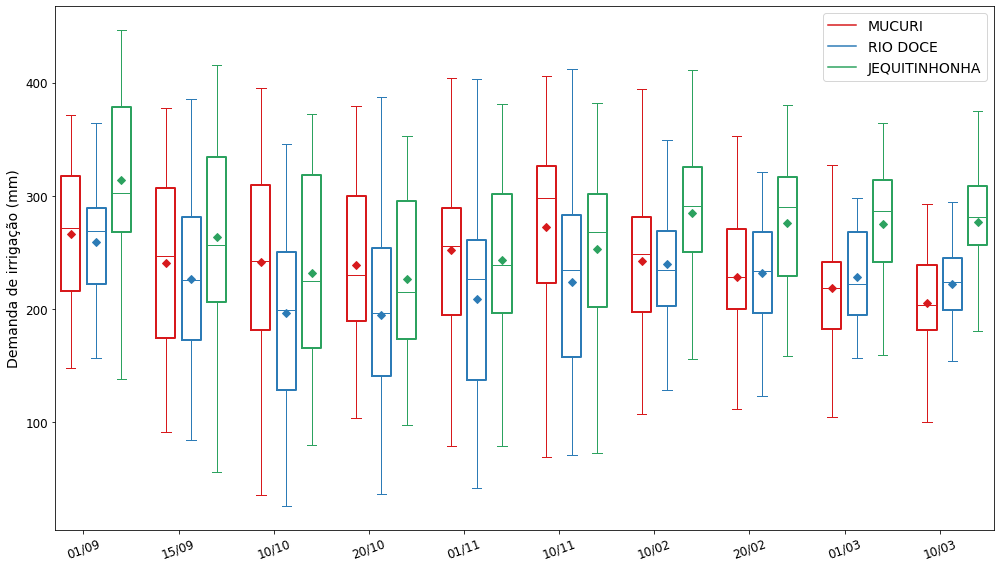

In [9]:
import matplotlib.pyplot as plt
import numpy as np

mucuri = I[0]
riodoce = I[1]
jequi = I[2]

ticks = ['01/09', '15/09', '10/10', '20/10', '01/11', '10/11', '10/02', '20/02', '01/03', '10/03']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(14,8))

bpm = plt.boxplot(mucuri, positions=np.array(range(len(mucuri)))*3.0-0.4, sym='', widths=0.6, showmeans=True, 
                  meanprops = dict(marker='D', markeredgecolor='#D7191C', markerfacecolor='#D7191C'),
                  boxprops = dict(linestyle='-', linewidth=2, color='darkgoldenrod'))
bpr = plt.boxplot(riodoce, positions=np.array(range(len(riodoce)))*3.0+0.4, sym='', widths=0.6, showmeans=True,
                  meanprops = dict(marker='D', markeredgecolor='#2C7BB6', markerfacecolor='#2C7BB6'),
                  boxprops = dict(linestyle='-', linewidth=2, color='darkgoldenrod'))
bpj = plt.boxplot(jequi, positions=np.array(range(len(jequi)))*3.0+1.2, sym='', widths=0.6, showmeans=True,
                  meanprops = dict(marker='D', markeredgecolor='#2CA25F', markerfacecolor='#2CA25F'),
                  boxprops = dict(linestyle='-', linewidth=2, color='darkgoldenrod'))
set_box_color(bpm, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')
set_box_color(bpj, '#2CA25F')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='MUCURI')
plt.plot([], c='#2C7BB6', label='RIO DOCE')
plt.plot([], c='#2CA25F', label='JEQUITINHONHA')
plt.legend()

plt.xticks(range(0, len(ticks) * 3, 3), ticks,rotation=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel('Demanda de irrigação (mm)', fontsize=14)
plt.legend(prop={"size":14})
plt.tight_layout()

In [10]:
frequencias = []
for i in range(8):
  freq = []
  ordenado = np.sort(I[0][i])
  for j in range(1,31):
    freq.append((30-j)/30*100) 
  frequencias.append(freq)

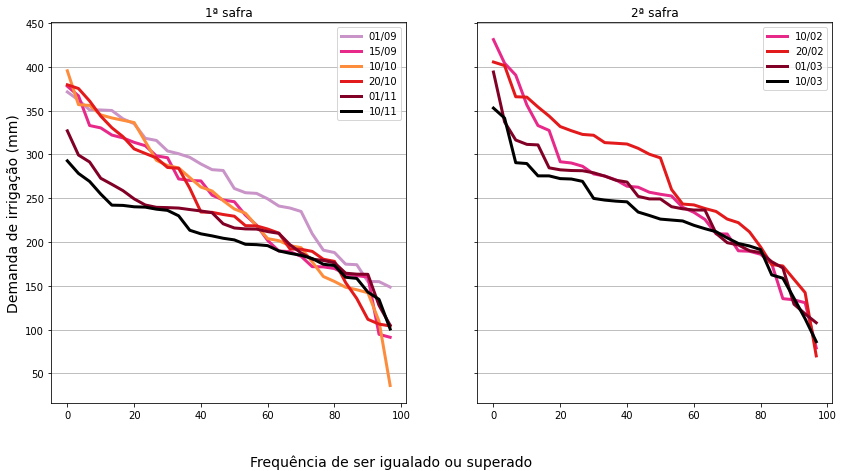

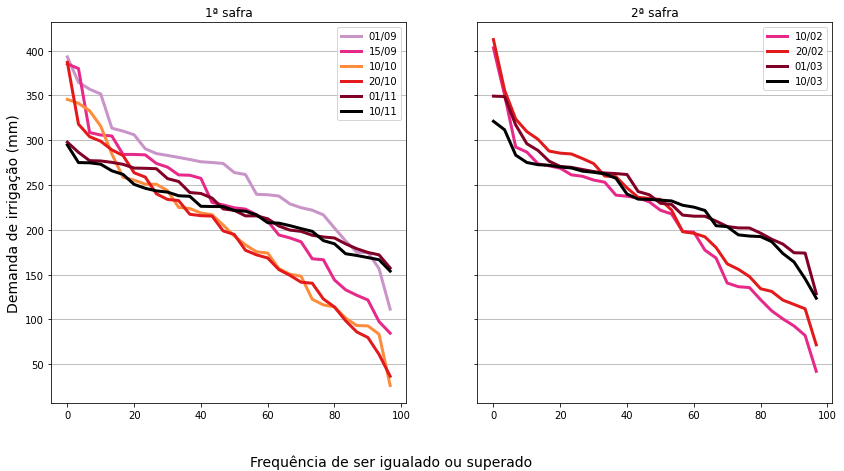

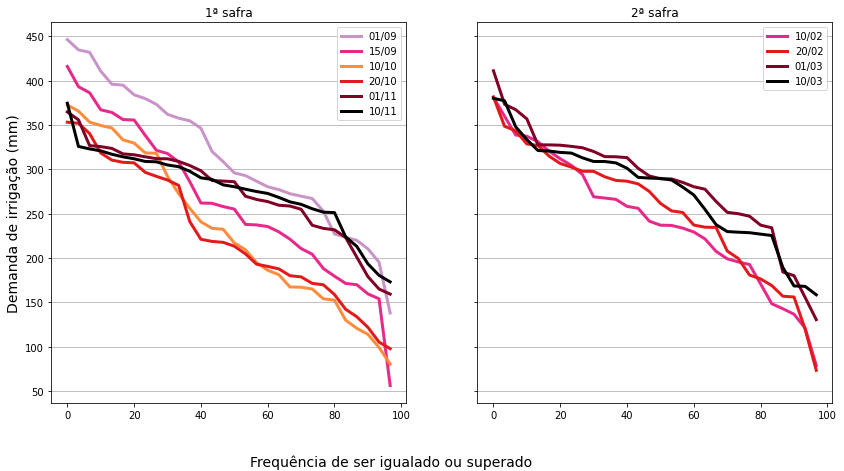

In [11]:
def plot_frequencias(local):
  frequencias = []
  for i in range(8):
    freq = []
    ordenado = np.sort(I[0][i])
    for j in range(1,31):
      freq.append((30-j)/30*100) 
    frequencias.append(freq)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
  ax1.set_ylabel('Demanda de irrigação (mm)', fontsize=14)
  ax1.set_title('1ª safra', fontsize=12)
  ax1.plot(frequencias[0], np.sort(I[local][0]), color='#c994c7', linewidth=3, label='01/09')
  ax1.plot(frequencias[1], np.sort(I[local][1]), color='#e7298a', linewidth=3, label='15/09')
  ax1.plot(frequencias[2], np.sort(I[local][2]), color='#fd8d3c', linewidth=3, label='10/10')
  ax1.plot(frequencias[3], np.sort(I[local][3]), color='#e31a1c', linewidth=3, label='20/10')
  ax1.plot(frequencias[6], np.sort(I[local][8]), color='#800026', linewidth=3, label='01/11')
  ax1.plot(frequencias[7], np.sort(I[local][9]), color='black', linewidth=3, label='10/11')
  ax1.yaxis.grid()
  ax1.legend()

  ax2.set_title('2ª safra', fontsize=12)
  ax2.plot(frequencias[4], np.sort(I[local][4]), color='#e7298a', linewidth=3, label='10/02')
  ax2.plot(frequencias[5], np.sort(I[local][5]), color='#e31a1c', linewidth=3, label='20/02')
  ax2.plot(frequencias[6], np.sort(I[local][6]), color='#800026', linewidth=3, label='01/03')
  ax2.plot(frequencias[7], np.sort(I[local][7]), color='black', linewidth=3, label='10/03')
  ax2.yaxis.grid()
  ax2.legend()

  plt.annotate('Frequência de ser igualado ou superado',
              xy=(250, 5), xycoords='figure pixels', fontsize=14)
  pass

plot_frequencias(local=0) #Mucuri
plot_frequencias(local=1) #Rio Doce
plot_frequencias(local=2) #Jequitinhonha